Number of bands in the raster: 3
binary_map shape after reading: (900, 900)
Raster Bounds:
Left: 29.99999999999997, Right: 119.99999999999096, Bottom: -59.99999999999099, Top: 30.0
Latitude resolution: 0.09999999999998999 degrees/pixel
Longitude resolution: 0.09999999999998999 degrees/pixel
Environmental data loaded successfully.
Start index: (115, 425)
Goal index: (340, 100)
Recovered Start Lat/Lon: (18.450000000001154, 72.54999999999572)
Recovered Goal Lat/Lon: (-4.049999999996594, 40.04999999999897)
A* Path Found.
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      3 |  0.000000E+00 |  2.881015E+02 |             - |             -
0.41707291944961633
     2 |      200 |      3 |  0.000000E+00 |  1.893566E+02 |  0.000000E+00 |             f
0.5308546875433203
     3 |      300 |      3 |  0.000000E+00 |  1.695766E+02 |  0.000000E+00 |             f
0.5049246249621488
     4 |      400 |      3 |  0.000000E+00 |  1.467233E

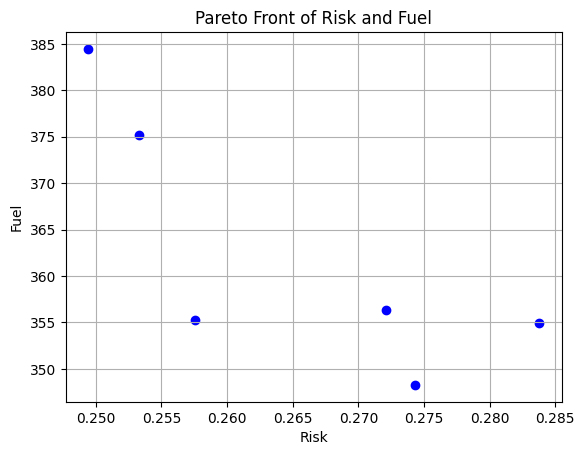

Best path found:
Decision Variables:  [[<__main__.Individual object at 0x00000288BE6C4E60>]
Objective Values:  [[   188.74      0.27 356288.78]
 [   177.28      0.27 348276.12]
 [   176.93      0.28 354966.9 ]
 [   189.77      0.26 355305.18]
 [   195.23      0.25 375173.08]
 [   205.74      0.25 384450.15]]
Constraints:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Created output\path1.csv
Created output\path2.csv
Created output\path3.csv
Created output\path4.csv
Created output\path5.csv
Created output\path6.csv
Files created: ['output\\path1.csv', 'output\\path2.csv', 'output\\path3.csv', 'output\\path4.csv', 'output\\path5.csv', 'output\\path6.csv']


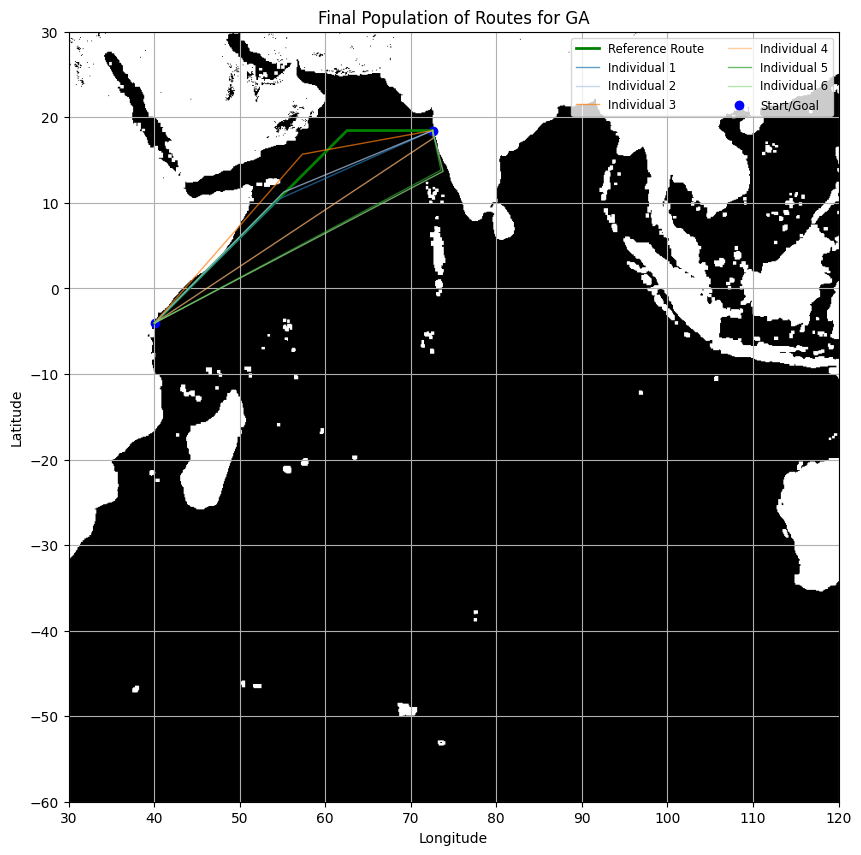

After 24 hours, the ship will be at latitude 17.612842, longitude 70.673280.


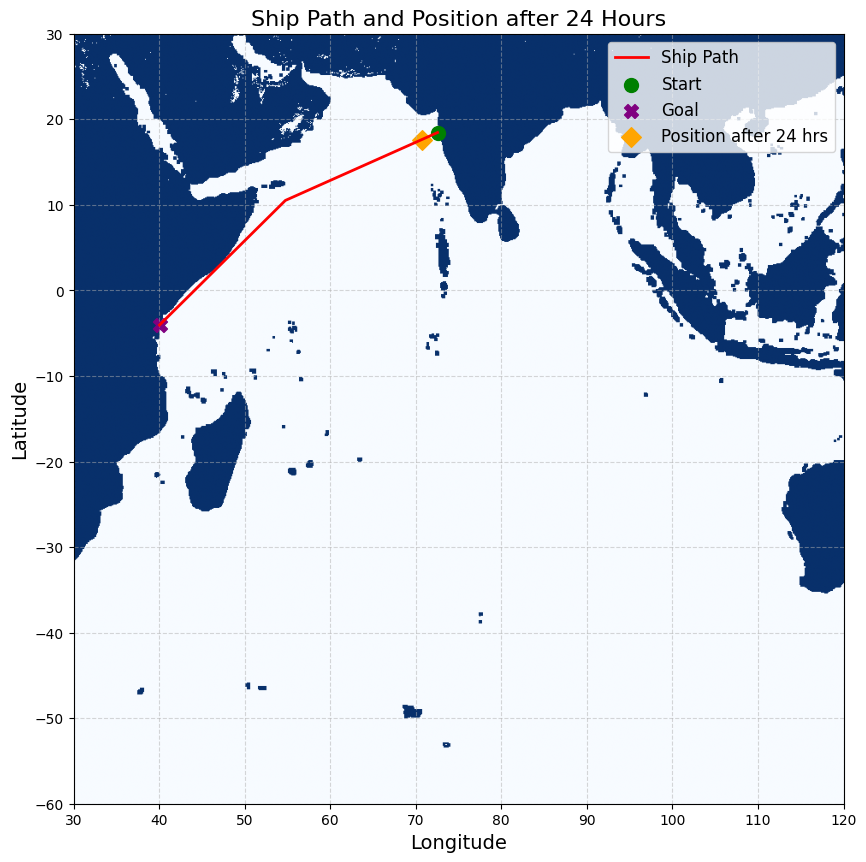

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
import os
import csv

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.sampling import Sampling
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.core.callback import Callback
from pymoo.optimize import minimize

ship_weight = 1000
a1=0.5
a2=0.5
Fb=2.0
V0=15
a=1.0
b=0.05
flag=True

def latlon_to_index(lat, lon, transform):
    """
    Converts latitude and longitude to map indices using Rasterio's transform.
    """
    col, row = ~transform * (lon, lat)
    col = int(col)
    row = int(row)
    return (row, col)

def index_to_latlon(row, col, transform):
    """
    Converts map indices back to latitude and longitude using Rasterio's transform.
    """
    lon, lat = transform * (col + 0.5, row + 0.5)
    return (lat, lon)

def valid_move(x, y, binary_map):
    """
    Check if a move is valid (within bounds and not on land).
    """
    return 0 <= x < binary_map.shape[0] and 0 <= y < binary_map.shape[1] and binary_map[x, y] == 0

def is_path_clear(lat1, lon1, lat2, lon2, transform, binary_map, num_samples=100):
    """
    Checks if the straight path between two waypoints crosses land.

    Parameters:
    - lat1, lon1: Latitude and longitude of the first waypoint
    - lat2, lon2: Latitude and longitude of the second waypoint
    - transform: Affine transform of the raster
    - binary_map: 2D numpy array representing land (1) and water (0)
    - num_samples: Number of samples along the path to check

    Returns:
    - True if the path is clear (all sampled points are water), False otherwise
    """

    lats = np.linspace(lat1, lat2, num_samples)
    lons = np.linspace(lon1, lon2, num_samples)
    
    for lat, lon in zip(lats, lons):
        try:
            row, col = latlon_to_index(lat, lon, transform)
            if not (0 <= row < binary_map.shape[0] and 0 <= col < binary_map.shape[1]):

                return False
            if binary_map[row, col] != 0:
                return False
        except:

            return False
    return True

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth's surface.
    Returns distance in nautical miles.
    """
    R = 3440.065
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the bearing from the first point to the second point.
    Returns bearing in degrees from north.
    """
    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    delta_lon_rad = math.radians(lon2 - lon1)

    x = math.sin(delta_lon_rad) * math.cos(lat2_rad)
    y = math.cos(lat1_rad) * math.sin(lat2_rad) - \
        math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon_rad)

    initial_bearing = math.atan2(x, y)
    initial_bearing_deg = (math.degrees(initial_bearing) + 360) % 360

    return initial_bearing_deg

def calculate_bearing_angle(heading, direction):
    """
    Calculates the smallest relative angle between two bearings.
    
    Parameters:
    - heading: Ship's heading in degrees
    - direction: Wind or wave direction in degrees
    
    Returns:
    - relative_angle: Smallest angle between the two directions (0 to 180 degrees)
    """
    if direction is None:
        return random.uniform(0, 180)
    relative_angle = abs(heading - direction) % 360
    relative_angle = min(relative_angle, 360 - relative_angle)
    return relative_angle

def calculate_actual_speed(V0, h, F, alpha, D=None, q=None):
    """
    Calculates the actual speed of the ship under winds and waves.
    
    Parameters:
    - V0: Hydrostatic speed of the ship (knots)
    - h: Significant wave height (meters)
    - F: Wind speed (knots)
    - alpha: Relative angle between ship's heading and wind direction (degrees)
    - D: Actual displacement of the ship (tons). If None, generate random value.
    - q: Relative angle between ship’s heading and wave direction (degrees). If None, generate random value.
    
    Returns:
    - Va: Actual speed of the ship (knots)
    """

    if D is None:
        D = random.uniform(5000, 20000)

    if q is None:
        q = random.uniform(0, 180)

    alpha_rad = math.radians(alpha)
    
    Va = (V0 
          - 1.08 * h 
          - 0.126 * q * h 
          + 2.77e-3 * F * math.cos(alpha_rad) 
          - 2.33e-7 * D * V0)
    
    Va = max(Va, 5.0)
    
    return Va

class Fitness:
    def __init__(self, transform, binary_map, wind_dir_data, wind_speed_data, wave_height_data):
        self.transform = transform
        self.binary_map = binary_map
        self.wind_dir_data = wind_dir_data
        self.wind_speed_data = wind_speed_data
        self.wave_height_data = wave_height_data

        self.u10max = np.max(wind_speed_data)
        if self.u10max == 0:
            self.u10max = 1

    def calculate_fitness(self, individual):
        """
        Calculates the total travel time, average risk, and total fuel consumption for a given route.
        
        Parameters:
        - individual: List of (lat, lon) tuples representing the route
        - V0: Hydrostatic speed of the ship (knots)
        - transform: Affine transform of the raster
        - wind_dir_data: 2D numpy array of wind directions (degrees from north)
        - wind_speed_data: 2D numpy array of wind speeds (knots)
        - wave_height_data: 2D numpy array of wave heights (meters)
        - wave_dir_data: 2D numpy array of wave directions (degrees from north). If None, handled in speed calculation
        - D: Actual displacement of the ship (tons). If None, generate random value per segment
        - a1: Weight for wind risk
        - a2: Weight for wave risk
        - Fb: Freeboard of the ship (meters)
        - a: Fuel consumption coefficient
        - b: Fuel consumption exponent
        - u10max: Maximum wind speed (knots). If None, it will be calculated.
        
        Returns:
        - total_time: Total travel time in hours
        - average_risk: Average risk across all segments
        - total_fuel: Total fuel consumption for the route
        """
        total_time = 0.0
        total_risk = 0.0
        total_fuel = 0.0
        num_segments = len(individual) - 1

        for i in range(num_segments):
            lat1, lon1 = individual[i]
            lat2, lon2 = individual[i + 1]
            

            heading = calculate_bearing(lat1, lon1, lat2, lon2)
            

            mid_lat = (lat1 + lat2) / 2
            mid_lon = (lon1 + lon2) / 2
            row, col = latlon_to_index(mid_lat, mid_lon, self.transform)
            

            if not (0 <= row < self.wind_dir_data.shape[0] and 0 <= col < self.wind_dir_data.shape[1]):
                print(f"Warning: Midpoint ({mid_lat}, {mid_lon}) is out of bounds. Assigning minimum speed and maximum risk.")
                Va = 5.0
                distance = haversine_distance(lat1, lon1, lat2, lon2)
                time = distance / Va
                total_time += time
                risk_i = 1.0
                total_risk += risk_i
                Qti = a * math.exp(b * Va)
                fuel_i = Qti * time
                total_fuel += fuel_i
                print(f"Segment {i+1}: Va={Va:.2f} knots, Time={time:.2f} hours, Fuel={fuel_i:.2f} units, Risk={risk_i:.2f}")
                print("-------------------------------")
                continue
            
            wind_dir = self.wind_dir_data[row, col]
            wind_speed = self.wind_speed_data[row, col]
            wave_height = self.wave_height_data[row, col]
            
            
            MAX_WAVE_HEIGHT = 10.0  
            MAX_WIND_SPEED = 100.0  
            wave_height = min(wave_height, MAX_WAVE_HEIGHT)
            wind_speed = min(wind_speed, MAX_WIND_SPEED)
            

            alpha = calculate_bearing_angle(heading, wind_dir)
            q = None
            

            current_D = random.uniform(5000, 20000)
            

            Va = calculate_actual_speed(V0=V0, h=wave_height, F=wind_speed, alpha=alpha, D=current_D, q=q)
            

            MIN_VA = 5.0
            if Va < MIN_VA:
                print(f"Warning: Va ({Va:.2f} knots) below minimum threshold. Adjusting to {MIN_VA} knots.")
                Va = MIN_VA
            

            distance = haversine_distance(lat1, lon1, lat2, lon2)
            time = distance / Va
            total_time += time
            

            relative_angle_rad = math.radians(alpha)
            ucross = wind_speed * math.sin(relative_angle_rad)
            risk_wind = ucross / self.u10max
            risk_wind = min(risk_wind, 1.0)
            risk_wave = wave_height / Fb
            risk_wave = min(risk_wave, 1.0)
            risk_i = a1 * risk_wind + a2 * risk_wave
            total_risk += risk_i
            

            Qti = a * math.exp(b * Va)
            fuel_i = Qti * time
            total_fuel += fuel_i
        
        average_risk = total_risk / num_segments
        return total_time, average_risk, total_fuel

import math
import random


def generate_initial_population(fitness: Fitness, reference_path, population_size=10, max_retries=100):
    """
    Generates an initial population for the genetic algorithm with updated fitness metrics.
    
    Parameters:
    - reference_path: List of tuples representing the reference route indices [(row, col), ...]
    - population_size: Number of individuals to generate
    - max_retries: Maximum number of attempts to find a valid waypoint
    
    Returns:
    - population: List of individuals, where each individual is a dictionary containing:
        - 'route': List of (lat, lon) tuples
        - 'total_time': Total travel time in hours
        - 'average_risk': Average risk across all segments
        - 'total_fuel': Total fuel consumption for the route
    """
    population = []
    attempts = 0
    max_total_attempts = population_size * max_retries * 2
    
    end_point = reference_path[-1]
    avg_len = 10

    while len(population) < population_size and attempts < max_total_attempts:
        current_point = reference_path[0]
        route = [index_to_latlon(current_point[0], current_point[1], fitness.transform)]
        path_direction = (end_point[0] - current_point[0], end_point[1] - current_point[1])
        path_magnitude = math.sqrt(path_direction[0]**2 + path_direction[1]**2)
        while current_point != end_point:
            end_direction = (end_point[0] - current_point[0], end_point[1] - current_point[1])

            magnitude = math.sqrt(end_direction[0]**2 + end_direction[1]**2)
            if magnitude < path_magnitude/avg_len and len(route) > 0:
                x = end_point[0]
                y = end_point[1]
                prev_lat, prev_lon = route[-1]
                lat, lon = index_to_latlon(x, y, fitness.transform)
                if valid_move(x, y, fitness.binary_map) and is_path_clear(prev_lat, prev_lon, lat, lon, fitness.transform, fitness.binary_map):
                    route.append((lat, lon))
                    current_point = (x, y)
                    break
            
            steps = 1 + max(0, avg_len - len(route))
            x = current_point[0] + int(random.normalvariate(end_direction[0]/steps, end_direction[0]/steps))
            y = current_point[1] + int(random.normalvariate(end_direction[1]/steps, end_direction[1]/steps))
            prev_lat, prev_lon = route[-1]
            lat, lon = index_to_latlon(x, y, fitness.transform)
            if valid_move(x, y, fitness.binary_map) and is_path_clear(prev_lat, prev_lon, lat, lon, fitness.transform, fitness.binary_map):
                route.append((lat, lon))
                current_point = (x, y)
            else:
                continue
        
        total_time, average_risk, total_fuel = fitness.calculate_fitness(route)

        if average_risk > 0.99:
            print(f"Warning: Individual {len(population)+1} has high risk ({average_risk:.2f}). Skipping.")
            continue
        else:
            individual_dict = {
                'route': route,
                'total_time': total_time,
                'average_risk': average_risk,
                'total_fuel': total_fuel
            }
            population.append(individual_dict)

    if len(population) < population_size:
        print(f"Error: Only generated {len(population)} unique valid individuals after {attempts} attempts.")
        print("Consider increasing 'max_total_attempts' or adjusting parameters.")
    
    return population

import heapq


def a_star_search(start, goal, binary_map, transform, ship_speed):
    """
    A* search algorithm to find the optimal path for the ship.
    """
    open_set = []
    heapq.heappush(open_set, (0, start))

    came_from = {}

    g_score = {start: 0}

    f_score = {start: heuristic(start[0], start[1], goal, transform, ship_speed)}

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]

    while open_set:
        current_f, current = heapq.heappop(open_set)
        current_x, current_y = current

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        for dx, dy in directions:
            neighbor_x, neighbor_y = current_x + dx, current_y + dy
            if valid_move(neighbor_x, neighbor_y, binary_map):
                tentative_g_score = g_score[current] + calculate_time(
                    current_x, current_y, neighbor_x, neighbor_y,
                    transform, ship_speed
                )

                neighbor = (neighbor_x, neighbor_y)
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f = tentative_g_score + heuristic(
                        neighbor_x, neighbor_y, goal,
                        transform, ship_speed
                    )
                    f_score[neighbor] = f
                    heapq.heappush(open_set, (f, neighbor))

    return None

def heuristic(x, y, goal, transform, ship_speed):
    """
    Heuristic function for A* (estimated time to goal).
    Uses straight-line distance divided by ship speed.
    """
    lat, lon = index_to_latlon(x, y, transform)
    goal_lat, goal_lon = index_to_latlon(goal[0], goal[1], transform)
    distance = haversine_distance(lat, lon, goal_lat, goal_lon)
    return distance / ship_speed

def calculate_time(x1, y1, x2, y2, transform, ship_speed):
    """
    Calculates the time to travel between two points based on ship speed.
    Uses the Haversine formula for distance calculation.
    """
    lat1, lon1 = index_to_latlon(x1, y1, transform)
    lat2, lon2 = index_to_latlon(x2, y2, transform)
    
    distance = haversine_distance(lat1, lon1, lat2, lon2)
    time = distance / ship_speed
    return time

import matplotlib.pyplot as plt

def plot_last_front(binary_map, transform, population, reference_path_latlon, start, goal, lon_min, lon_max, lat_min, lat_max):
    """
    Plots the initial population of routes on the map with each route in a different color.
    
    Parameters:
    - binary_map: 2D numpy array representing the map
    - transform: Affine transform of the raster
    - population: List of individuals, each a list of (lat, lon) tuples
    - reference_path_latlon: List of (lat, lon) tuples for the reference route
    - start: (lat, lon) tuple for the start point
    - goal: (lat, lon) tuple for the goal point
    - lon_min, lon_max, lat_min, lat_max: Bounds for plotting
    """
    plt.figure(figsize=(12, 10))
    ax = plt.gca()
    
    plt.imshow(binary_map, cmap='gray', extent=[lon_min, lon_max, lat_min, lat_max], origin='upper')

    ref_lats = [p[0] for p in reference_path_latlon]
    ref_lons = [p[1] for p in reference_path_latlon]
    plt.plot(ref_lons, ref_lats, color='green', linewidth=2, label='Reference Route')
    

    cmap = plt.get_cmap('tab20')
    num_colors = cmap.N
    colors = [cmap(i) for i in range(num_colors)]
    
    for idx, individual in enumerate(population):
        lats = [p[0] for p in individual]
        lons = [p[1] for p in individual]
        color = colors[idx % num_colors]
        plt.plot(lons, lats, linewidth=1, alpha=0.7, color=color, label=f'Individual {idx+1}' if idx < 10 else "")
    
    plt.scatter([start[1], goal[1]], [start[0], goal[0]], color='blue', marker='o', label='Start/Goal')
    
    plt.title('Final Population of Routes for GA')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small', ncol=2)
    
    plt.grid(True)
    plt.show()

def plot_population(binary_map, transform, population, reference_path_latlon, start, goal, lon_min, lon_max, lat_min, lat_max, generation):
    """
    Plots the population of routes on the map with each route in a different color.

    Parameters:
    - binary_map: 2D numpy array representing the map
    - transform: Affine transform of the raster
    - population: List of individuals, each a dictionary with a 'route' key
    - reference_path_latlon: List of (lat, lon) tuples for the reference route
    - start: (lat, lon) tuple for the start point
    - goal: (lat, lon) tuple for the goal point
    - lon_min, lon_max, lat_min, lat_max: Bounds for plotting
    - generation: Current generation number
    """
    plt.figure(figsize=(12, 10))
    ax = plt.gca()
    
    plt.imshow(binary_map, cmap='gray', extent=[lon_min, lon_max, lat_min, lat_max], origin='upper')
    
    ref_lats = [p[0] for p in reference_path_latlon]
    ref_lons = [p[1] for p in reference_path_latlon]
    plt.plot(ref_lons, ref_lats, color='green', linewidth=2, label='Reference Route')
    
    cmap = plt.get_cmap('tab20')
    num_colors = cmap.N
    colors = [cmap(i) for i in range(num_colors)]
    
    for idx, individual in enumerate(population):
        lats = [p[0] for p in individual]
        lons = [p[1] for p in individual]
        color = colors[idx % num_colors]
        plt.plot(lons, lats, linewidth=1, alpha=0.7, color=color, label=f'Individual {idx+1}' if idx < 10 else "")
    
    plt.scatter([start[1], goal[1]], [start[0], goal[0]], color='blue', marker='o', label='Start/Goal')
    
    plt.title(f'Population Routes - Generation {generation}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small', ncol=2)
    
    plt.grid(True)
    plt.show()



class Individual:
    def __init__(self, path):
        self.path = path
    
    def copy(self):
        return Individual(self.path[:])
    
    def mutate(self, sigma, transform, binary_map):
        ans = self.copy()
        if len(self.path) > 2:
            for _ in range(len(self.path)):
                mutation_point = random.randint(1, len(self.path) - 2)
                x = random.normalvariate(0, sigma)
                y = random.normalvariate(0, sigma)
                new_point = (self.path[mutation_point][0] + x, self.path[mutation_point][1] + y)
                if is_path_clear(self.path[mutation_point-1][0], self.path[mutation_point-1][1], new_point[0], new_point[1], transform, binary_map) and is_path_clear(self.path[mutation_point+1][0], self.path[mutation_point+1][1], new_point[0], new_point[1], transform, binary_map):
                    ans.path[mutation_point] = new_point
        
        if random.random() < 0.1 and len(self.path) > 3:
            mutation_point = random.randint(1, len(self.path) - 2)
            if is_path_clear(self.path[mutation_point-1][0], self.path[mutation_point-1][1], self.path[mutation_point+1][0], self.path[mutation_point+1][1], transform, binary_map):
                ans.path.pop(mutation_point)
        
        return ans

class MySampling(Sampling):
    def __init__(self, reference_path):
        self.reference_path = reference_path
        super().__init__()
    
    def _do(self, problem, n_samples, **kwargs):
        individuals = generate_initial_population(problem.fitness, self.reference_path, n_samples)
        individuals = [Individual(individual["route"]) for individual in individuals]
        X = np.array(individuals, dtype=Individual)
        return X[..., np.newaxis]

def calculate_angle(P1, P2, P3):
    x1, y1 = P2[0] - P1[0], P2[1] - P1[1]
    x2, y2 = P3[0] - P2[0], P3[1] - P2[1]
    angle_radians = math.atan2(y2, x2) - math.atan2(y1, x1)
    angle_degrees = abs(math.degrees(angle_radians))
    if angle_degrees > 180:
        angle_degrees = 380 - angle_degrees
    return angle_degrees

max_turn_angle = 60
def angle_constraint(path):
    return sum([ max(0, calculate_angle(path[i-1], path[i], path[i+1]) - max_turn_angle) for i in range(1, len(path) - 2)])

class PathProblem(Problem):
    def __init__(self, fitness: Fitness):
        self.fitness = fitness
        super().__init__(n_var=1, n_obj=3, n_ieq_constr=1, vtype=dict)
        
    def _evaluate(self, x, out, *args, **kwargs):
        total_time, average_risk, total_fuel = np.vectorize(lambda x: self.fitness.calculate_fitness(x.path))(x)
        constraint = np.vectorize(lambda x: angle_constraint(x.path))(x)
        out["F"] = np.column_stack([total_time, average_risk, total_fuel])
        out["G"] = np.column_stack([constraint])


def find_closest_point(point, path):
    path = np.array(path[1:])
    return 1+np.argmin((path[:,0]-point[0])**2 + (path[:,1]-point[1])**2)


class PathCrossover(Crossover):
    def __init__(self, prob, transform, binary_map):
        super().__init__(2, 2, prob)
        self.transform = transform
        self.binary_map = binary_map

    def _do(self, problem, X, **kwargs):
        n_parents, n_mating, n_vars = X.shape

        child1 = []
        child2 = []

        for i in range(n_mating):
            parent1 = X[0][i][0].path
            parent2 = X[1][i][0].path
            crossover_point1 = random.randint(1, len(parent1) - 1)
            crossover_point2 = find_closest_point(parent1[crossover_point1], parent2)
            if is_path_clear(parent1[crossover_point1-1][0], parent1[crossover_point1-1][1], parent2[crossover_point2][0], parent2[crossover_point2][1], self.transform, self.binary_map) and is_path_clear(parent2[crossover_point2-1][0], parent2[crossover_point2-1][1], parent1[crossover_point1][0], parent1[crossover_point1][1], self.transform, self.binary_map):
                child1.append(Individual(parent1[:crossover_point1] + parent2[crossover_point2:]))
                child2.append(Individual(parent2[:crossover_point2] + parent1[crossover_point1:]))
            else:
                child1.append(Individual(parent1[:]))
                child2.append(Individual(parent2[:]))
        
        return np.array([child1, child2])[..., np.newaxis]


class PathMutation(Mutation):
    def __init__(self, sigma, transform, binary_map):
        super().__init__()
        self.sigma = sigma
        self.transform = transform
        self.binary_map = binary_map
    
    def _do(self, problem, individuals, **kwargs):
        return np.vectorize(lambda x: x.mutate(self.sigma, self.transform, self.binary_map))(individuals)

class MyDuplicateElimination(ElementwiseDuplicateElimination):

    def is_equal(self, a, b):
        return False

class MyCallback(Callback):
    def __init__(self) -> None:
        super().__init__()

    def notify(self, algorithm):
        pass
        print(algorithm.pop.get("F").min())
import pandas as pd
def save_to_csv1(res,x_filename='res_F.csv'):
    df_F = pd.DataFrame(res.F)

    df_F.to_csv(x_filename, index=False,header=False)
def run(fitness, reference_path):

    algorithm = NSGA2(
        pop_size=100,
        n_offsprings=100,
        crossover=PathCrossover(prob=1.0, transform=fitness.transform, binary_map=fitness.binary_map),
        mutation=PathMutation(sigma=10.0, transform=fitness.transform, binary_map=fitness.binary_map),
        sampling=MySampling(reference_path),
        eliminate_duplicates=MyDuplicateElimination(),
    )

    problem = PathProblem(fitness)

    res = minimize(problem,
                algorithm,
                termination=('n_gen', 100),
                verbose=True,
                callback=MyCallback())

    plt.scatter(res.F[:, 1], res.F[:, 2], color='b')
    plt.xlabel("Risk")
    plt.ylabel("Fuel")
    plt.title("Pareto Front of Risk and Fuel")
    plt.grid(True)
    plt.show()

    print("Best path found:")
    print("Decision Variables: ", res.X)
    res.F[:, -1] *= ship_weight
    np.set_printoptions(precision=2, suppress=True)
    print("Objective Values: ", np.round(res.F, 2))
    save_to_csv1(res)
    res.F[:, -1] /= ship_weight
    print("Constraints: ", res.G)

    return [x[0].path for x in res.X]

def get_coordinate_after_t_hours(path, fitness, t):
    """
    Calculates the coordinate where the ship will be after t hours along the given path.
    
    Parameters:
    - path: List of (lat, lon) tuples representing the route.
    - fitness: Fitness object containing environmental data and methods.
    - t: Time in hours after which to find the ship's coordinate.
    
    Returns:
    - (lat, lon): Tuple representing the ship's position after t hours.
    """
    total_time = 0.0
    
    for i in range(len(path) - 1):
        lat1, lon1 = path[i]
        lat2, lon2 = path[i + 1]
        
        heading = calculate_bearing(lat1, lon1, lat2, lon2)
        
        mid_lat = (lat1 + lat2) / 2
        mid_lon = (lon1 + lon2) / 2
        
        row, col = latlon_to_index(mid_lat, mid_lon, fitness.transform)
        
        if not (0 <= row < fitness.wind_dir_data.shape[0] and 0 <= col < fitness.wind_dir_data.shape[1]):
            Va = 5.0
        else:
            wind_dir = fitness.wind_dir_data[row, col]
            wind_speed = fitness.wind_speed_data[row, col]
            wave_height = fitness.wave_height_data[row, col]

            MAX_WAVE_HEIGHT = 10.0
            MAX_WIND_SPEED = 100.0
            wave_height = min(wave_height, MAX_WAVE_HEIGHT)
            wind_speed = min(wind_speed, MAX_WIND_SPEED)
            
            alpha = calculate_bearing_angle(heading, wind_dir)
            
            Va = calculate_actual_speed(V0=V0, h=wave_height, F=wind_speed, alpha=alpha)
        
        distance = haversine_distance(lat1, lon1, lat2, lon2)
        time = distance / Va
        
        if total_time + time >= t:
            remaining_time = t - total_time
            fraction = remaining_time / time
            
            lat = lat1 + (lat2 - lat1) * fraction
            lon = lon1 + (lon2 - lon1) * fraction
            return (lat, lon)
        else:
            total_time += time
    
    return path[-1]

def plot_path_with_position(binary_map, transform, path_latlon, position, start, goal, lon_min, lon_max, lat_min, lat_max, t):
    """
    Plots the navigational map, the ship's path, and the position after t hours.

    Parameters:
    - binary_map (np.ndarray): 2D array representing land (1) and water (0).
    - transform (Affine): Affine transform for geospatial referencing.
    - path_latlon (list of tuples): List of (latitude, longitude) tuples representing the ship's path.
    - position (tuple): (latitude, longitude) tuple representing the ship's position after t hours.
    - start (tuple): (latitude, longitude) tuple for the start point.
    - goal (tuple): (latitude, longitude) tuple for the goal point.
    - lon_min (float): Minimum longitude for plotting.
    - lon_max (float): Maximum longitude for plotting.
    - lat_min (float): Minimum latitude for plotting.
    - lat_max (float): Maximum latitude for plotting.
    - t (float): Time in hours after which to plot the ship's position.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 10))
    ax = plt.gca()

    plt.imshow(binary_map, cmap='Blues', extent=[lon_min, lon_max, lat_min, lat_max], origin='upper')

    lats = [point[0] for point in path_latlon]
    lons = [point[1] for point in path_latlon]
    plt.plot(lons, lats, color='red', linewidth=2, label='Ship Path')

    plt.scatter([start[1]], [start[0]], color='green', marker='o', s=100, label='Start')
    plt.scatter([goal[1]], [goal[0]], color='purple', marker='X', s=100, label='Goal')

    if position:
        plt.scatter([position[1]], [position[0]], color='orange', marker='D', s=100, label=f'Position after {t} hrs')

    plt.title(f'Ship Path and Position after {t} Hours', fontsize=16)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.xlim(lon_min, lon_max)
    plt.ylim(lat_min, lat_max)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()


def save_to_csv2(path):
    os.makedirs('output', exist_ok=True)
    created_files = []
    for i, coordinates in enumerate(path, 1):
        filename = os.path.join('output', f'path{i}.csv')
        with open(filename, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['Latitude', 'Longitude'])
            csvwriter.writerows(coordinates)
        created_files.append(filename)
        print(f"Created {filename}")
    
    return created_files

def main():
    global ecological_area,pirate_risk_map
    binary_file = "indian_ocean_binary.tif"
    target_height, target_width = 900, 900

    try:
        with rasterio.open(binary_file) as src:
            band_count = src.count
            print(f"Number of bands in the raster: {band_count}")
            
            if band_count >= 1:
                binary_map = src.read(
                    1,
                    out_shape=(target_height, target_width),
                    resampling=Resampling.nearest
                )
                transform = src.transform * src.transform.scale(
                    (src.width / binary_map.shape[1]),
                    (src.height / binary_map.shape[0])
                )
            else:
                raise ValueError("Raster file does not contain any bands.")
    except FileNotFoundError:
        print(f"Error: The file '{binary_file}' was not found.")
        return
    except Exception as e:
        print(f"An error occurred while reading '{binary_file}': {e}")
        return
    
    print(f"binary_map shape after reading: {binary_map.shape}")
    ecological_area=np.zeros((target_height,target_width))

    data=[[[-5,-7],[71,73]],[[-9,-10],[46,47]],[[6,7],[93,94]],[[-3,-5],[56,57]]]
    for i in data:

        i1,j1=latlon_to_index(i[0][0],i[1][0],transform)
        i2,j2=latlon_to_index(i[0][1],i[1][1],transform)

        for k in range(min(i1,i2),max(i1,i2)):
            for p in range(min(j1,j2),max(j1,j2)):

                ecological_area[k][p]=1

    with rasterio.open(binary_file) as src:
        bounds = src.bounds
        print(f"Raster Bounds:\nLeft: {bounds.left}, Right: {bounds.right}, Bottom: {bounds.bottom}, Top: {bounds.top}")

    lat_min, lat_max = bounds.bottom, bounds.top
    lon_min, lon_max = bounds.left, bounds.right
    lat_res = (lat_max - lat_min) / binary_map.shape[0]
    lon_res = (lon_max - lon_min) / binary_map.shape[1]
    print(f"Latitude resolution: {lat_res} degrees/pixel")
    print(f"Longitude resolution: {lon_res} degrees/pixel")

    pirate_risk_map = np.zeros((target_height, target_width))
    
    for i in range (100,200):
        for j in range(200,380):
            pirate_risk_map[i][j]=0.5
    for i in range (200,400):
        for j in range(180,380):
            pirate_risk_map[i][j]=0.2
    for i in range (200,400):
        for j in range(700,900):
            pirate_risk_map[i][j]=0.2    

    try:
        global flag
        if flag:
            wave_height_data = np.load('wave_height_data.npy')
            wind_dir_data = np.load('wind_dir_data.npy')
            wind_speed_data = np.load('wind_speed_data.npy')

        else:
            wave_height_data=np.load('wave_height_data2.npy')
            wind_dir_data = np.load('wind_dir_data2.npy')
            wind_speed_data = np.load('wind_speed_data2.npy') 
        try:
            wave_dir_data = np.load('wave_dir_data.npy')
            print("Wave direction data loaded successfully.")
        except FileNotFoundError:
            print("Warning: 'wave_dir_data.npy' not found. Wave direction will be randomized.")
            wave_dir_data = None
        print("Environmental data loaded successfully.")
    except FileNotFoundError:
        print("Warning: One or more environmental data files not found. Continuing without them.")
        wave_height_data = np.zeros_like(binary_map)
        wind_dir_data = np.zeros_like(binary_map)
        wind_speed_data = np.zeros_like(binary_map)
        wave_dir_data = None
    except Exception as e:
        print(f"An error occurred while loading environmental data: {e}")
        print("Continuing without them.")
        wave_height_data = np.zeros_like(binary_map)
        wind_dir_data = np.zeros_like(binary_map)
        wind_speed_data = np.zeros_like(binary_map)
        wave_dir_data = None

    start_lat, start_lon = 18.5, 72.5
    goal_lat, goal_lon = -4, 40

    start = latlon_to_index(start_lat, start_lon, transform)
    goal = latlon_to_index(goal_lat, goal_lon, transform)

    print(f"Start index: {start}")
    print(f"Goal index: {goal}")

    recovered_start_latlon = index_to_latlon(start[0], start[1], transform)
    recovered_goal_latlon = index_to_latlon(goal[0], goal[1], transform)

    print(f"Recovered Start Lat/Lon: {recovered_start_latlon}")
    print(f"Recovered Goal Lat/Lon: {recovered_goal_latlon}")

    if not valid_move(start[0], start[1], binary_map):
        raise ValueError("Start point is on land. Please choose a different start location.")
    if not valid_move(goal[0], goal[1], binary_map):
        raise ValueError("Goal point is on land. Please choose a different goal location.")

    path = a_star_search(start, goal, binary_map, transform, ship_speed=V0)

    if path is None:
        print("No path found from start to goal.")
        return
    else:
        print("A* Path Found.")

    path_latlon = [index_to_latlon(x, y, transform) for x, y in path]

    fitness = Fitness(transform, binary_map, wind_dir_data, wind_speed_data, wave_height_data)

    paths = run(fitness, path)
    created_files =save_to_csv2(paths)
    print("Files created:", created_files)

    # plot_population(binary_map, transform, paths, path_latlon, recovered_start_latlon, recovered_goal_latlon, lon_min, lon_max, lat_min, lat_max, 100)
    plot_last_front(binary_map, transform, paths, path_latlon, recovered_start_latlon, recovered_goal_latlon, lon_min, lon_max, lat_min, lat_max)

    t = 24
    if paths:
        primary_path = paths[0]
        position = get_coordinate_after_t_hours(primary_path, fitness, t)
        print(f"After {t} hours, the ship will be at latitude {position[0]:.6f}, longitude {position[1]:.6f}.")
        
        plot_path_with_position(
            binary_map=binary_map,
            transform=transform,
            path_latlon=primary_path,
            position=position,
            start=recovered_start_latlon,
            goal=recovered_goal_latlon,
            lon_min=lon_min,
            lon_max=lon_max,
            lat_min=lat_min,
            lat_max=lat_max,
            t=t
        )
    else:
        print("No paths available to determine ship position.")

if __name__ == "__main__":
    main()